In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

## Longstaff Schwarz Algo (Benchmark)

In [2]:
# Model parameters
T = 1.0  # Total time in years
N = 100  # Number of time steps
dt = T / N
t = np.linspace(0, T, N+1)  # Time grid for simulation
r = 0.05  # Risk-free rate
sigma = 0.2  # Annual volatility of the underlying asset
M = 1000  # Number of simulated paths
K = 120  # Strike price
S0 = 100  # Initial stock price
degree = 4
t = np.linspace(0, T, N+1) 


In [3]:
# Functions from RLLN notebook

def stock_price_simulator(S0, mu, sigma, T, N, M):
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, M))
    return S

# Define the payoff function for a put option
def payoff_fun(S, K):
    return np.maximum(K - S, 0)

def black_scholes(S, K, r, sigma, T, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

#### Helper functions

In [4]:

# Define the discount factor function
def discount_factor(t_from, t_to):
    return np.exp(-r * (t_to - t_from))

# Define the function to select in-the-money paths
def itm(payoff):
    return payoff > 0

#### Longstaff Schwartz

In [8]:


# Define the discount factor function
def discount_factor(t_from, t_to):
    return np.exp(-r * (t_to - t_from))

# Define the function to select in-the-money paths
def itm(payoff):
    return payoff > 0

# Implement the Longstaff-Schwartz algorithm
def longstaff_schwartz(stock_paths, t, discount_factor_func, payoff_func, itm_func):
    N = stock_paths.shape[0] - 1  # Number of time steps
    M = stock_paths.shape[1]      # Number of paths

    # Initialize the option values at maturity
    V = payoff_func(stock_paths[-1, :], K)

    # Array to store values for visualization
    option_values = np.zeros_like(stock_paths)

    # Time loop backward from N-1 to 1
    for n in range(N-1, 0, -1):
        spot = stock_paths[n, :]
        payoff = payoff_func(spot, K)
        in_the_money = itm_func(payoff)

        option_values[n, :] = V  # Store values for analysis

        if np.any(in_the_money):
            # Regression to estimate continuation value
            X = spot[in_the_money]
            Y = V[in_the_money] * discount_factor_func(t[n], t[n+1])

            # Construct the feature matrix with polynomial basis functions
            features = np.vstack([X**i for i in range(degree)]).T

            # Fit the linear regression model
            reg = LinearRegression().fit(features, Y)
            continuation_value = reg.predict(np.vstack([spot**i for i in range(degree)]).T)

            # Decide whether to exercise or continue
            exercise = payoff > continuation_value
            V = np.where(exercise, payoff, V * discount_factor_func(t[n], t[n+1]))
        else:
            # Discount option value for out-of-the-money paths
            V = V * discount_factor_func(t[n], t[n+1])

    # Calculate the option price at time 0
    option_price = np.mean(V * discount_factor_func(t[0], t[1]))

    # Store values at initial time
    option_values[0, :] = V * discount_factor_func(t[0], t[1])
    return option_price, option_values

# Simulate stock price paths
mu = r  # Assuming risk-neutral measure
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, M)

# Run the Longstaff-Schwartz algorithm
mean_option_price, option_values = longstaff_schwartz(stock_paths.T, t, discount_factor, payoff_fun, itm)
print(f"Estimated American Put Option Price: {mean_option_price:.4f}")


# Calculate the Black-Scholes price for a European put option
bs_price = black_scholes(S0, K, r, sigma, T, option_type='put')
print(f"Theoretical European Put Option Price (Black-Scholes): {bs_price:.4f}")



# Visualization
mid_point = len(t) // 2
stock_prices_mid = stock_paths[:, mid_point]
payoff_mid = payoff_fun(stock_prices_mid, K)

# Identify in-the-money paths at the midpoint
in_the_money = itm(payoff_mid)

# Regression to estimate continuation value at the midpoint
X_mid = stock_prices_mid[in_the_money]
Y_mid = option_values[mid_point, in_the_money] * discount_factor(t[mid_point], t[-1])

# Construct the feature matrix for in-the-money paths
features_mid = np.vstack([X_mid**i for i in range(degree)]).T

# Fit the linear regression model
regression = LinearRegression().fit(features_mid, Y_mid)
continuation_value_mid = regression.predict(np.vstack([stock_prices_mid**i for i in range(4)]).T)


Estimated American Put Option Price: 19.9805


NameError: name 'norm' is not defined

## First run

In [6]:
# Simulate stock price paths
mu = r  # Assuming risk-neutral measure
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, M)

# Run the Longstaff-Schwartz algorithm
mean_option_price, option_values = longstaff_schwartz(stock_paths.T, t, discount_factor, payoff_fun, itm)
print(f"Estimated American Put Option Price: {mean_option_price:.4f}")

# Identify paths at the midpoint
mid_point = len(t) // 2
stock_prices_mid = stock_paths[:, mid_point]
payoff_mid = payoff_fun(stock_prices_mid, K)

# Identify in-the-money paths at the midpoint
in_the_money = itm(payoff_mid)

# Regression to estimate continuation value at the midpoint
X_mid = stock_prices_mid[in_the_money]
Y_mid = option_values[mid_point, in_the_money] * discount_factor(t[mid_point], t[-1])

# Construct the feature matrix for in-the-money paths
features_mid = np.vstack([X_mid**i for i in range(degree)]).T

# Fit the linear regression model
regression = LinearRegression().fit(features_mid, Y_mid)
continuation_value_mid = regression.predict(np.vstack([stock_prices_mid**i for i in range(4)]).T)


Estimated American Put Option Price: 20.2240


## Plotting

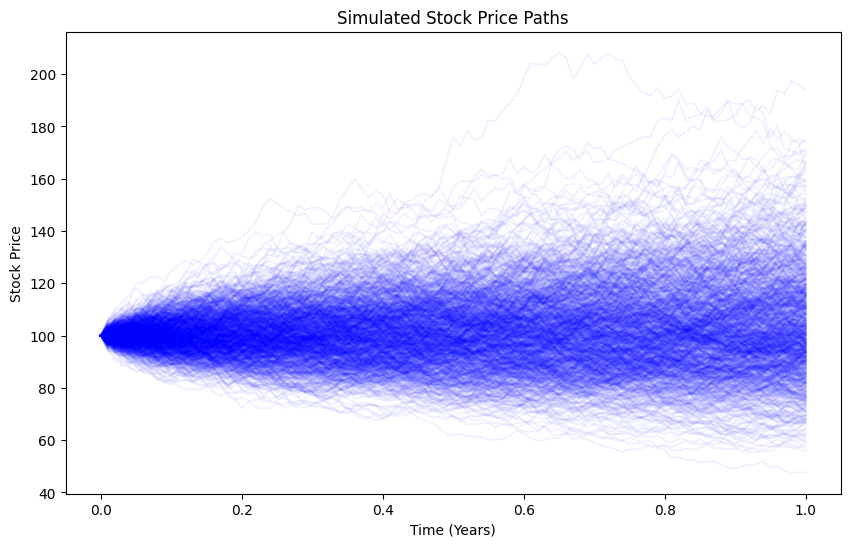

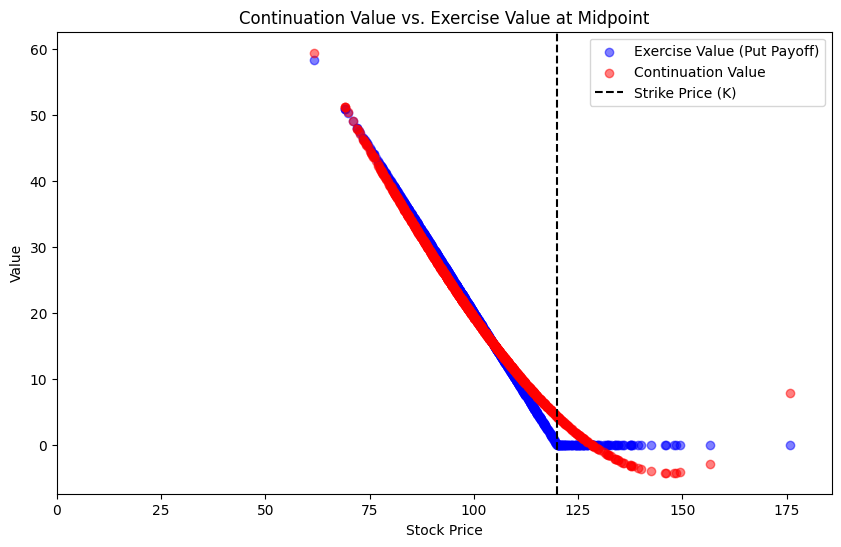

In [7]:

# Plot the simulated stock paths
plt.figure(figsize=(10, 6))
for path in stock_paths:
    plt.plot(t, path, color='blue', alpha=0.05)
plt.title("Simulated Stock Price Paths")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.show()

# Plot continuation value and exercise value
exercise_value = payoff_fun(stock_prices_mid, K)
plt.figure(figsize=(10, 6))
plt.scatter(stock_prices_mid, exercise_value, label="Exercise Value (Put Payoff)", color="blue", alpha=0.5)
plt.scatter(stock_prices_mid, continuation_value_mid, label="Continuation Value", color="red", alpha=0.5)
plt.axvline(x=K, color="black", linestyle="--", label="Strike Price (K)")
plt.title("Continuation Value vs. Exercise Value at Midpoint")
plt.xlabel("Stock Price")
plt.ylabel("Value")
plt.xlim(0, max(stock_prices_mid) + 10)
plt.legend()
plt.show()